<a href="https://colab.research.google.com/github/FLCL4LIFE/Work-Done-in-Classes/blob/main/tree_nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [14]:
import datetime
from graphviz import Digraph

class UserNode:
    def __init__(self, user_id, name, is_active, last_activity):
        self.user_id = user_id
        self.name = name
        self.is_active = is_active
        self.last_activity = last_activity  # Timestamp of the last activity
        self.children = []

    def add_child(self, child_node):
        self.children.append(child_node)


class UserTree:
    def __init__(self):
        self.root = None
        self.archive = []  # List to store archived nodes

    def set_root(self, root_node):
        self.root = root_node

    def add_user(self, user_node, parent_node=None):
        if self.root is None:
            self.set_root(user_node)
        else:
            parent_node.add_child(user_node)

    def archive_inactive_users(self, node=None, inactive_period_days=365):
        if node is None:
            node = self.root

        current_time = datetime.datetime.now()
        inactive_period = datetime.timedelta(days=inactive_period_days)

        for child in node.children[:]:  # Make a copy of the list to avoid modification during iteration
            self.archive_inactive_users(child, inactive_period_days)

        if not node.is_active:
            last_active_date = node.last_activity
            if current_time - last_active_date > inactive_period:
                self.archive.append(node)
                node.children = []  # Remove children to simulate archiving
                if node in self.root.children:
                    self.root.children.remove(node)
                else:
                    for parent in self.root.children:
                        if node in parent.children:
                            parent.children.remove(node)

    def visualize_tree(self, node=None, graph=None, parent_id=None):
        if graph is None:
            graph = Digraph()
            graph.attr('node', shape='circle')
            node = self.root

        if node:
            node_id = f'{node.user_id}_{node.name}'
            graph.node(node_id, f'{node.name}\n{"Active" if node.is_active else "Inactive"}')

            if parent_id:
                graph.edge(parent_id, node_id)

            for child in node.children:
                self.visualize_tree(child, graph, node_id)

        return graph

    def visualize_archived(self):
        graph = Digraph()
        graph.attr('node', shape='circle', style='filled', color='lightgrey')
        for node in self.archive:
            graph.node(f'{node.user_id}_{node.name}', f'{node.name}')

        return graph

# Example Usage
tree = UserTree()
current_time = datetime.datetime.now()

# Adding root user
truconnect = UserNode(1, "TruConnect", True, current_time)
tree.add_user(truconnect)

agent_id = 2
customer_id = 100

# Adding agents and customers
for i in range(10):
    agent = UserNode(agent_id, f"Agent_{i+1}", True, current_time)
    tree.add_user(agent, truconnect)

    # Adding customers under each agent
    for j in range(5):
        is_active = (j % 2 == 0)  # Half active, half inactive
        customer = UserNode(customer_id, f"Customer_{customer_id}", is_active, current_time - datetime.timedelta(days=(400 if not is_active else 30)))
        tree.add_user(customer, agent)
        customer_id += 1

    agent_id += 1

# Visualize the tree before archiving
tree_graph = tree.visualize_tree()
tree_graph.render('tree_before_archiving', format='png', cleanup=True)

# Archive inactive users who have been inactive for more than a year (365 days)
tree.archive_inactive_users(inactive_period_days=365)

# Visualize the tree after archiving
tree_graph_after = tree.visualize_tree()
tree_graph_after.render('tree_after_archiving', format='png', cleanup=True)

# Visualize archived nodes
archived_graph = tree.visualize_archived()
archived_graph.render('archived_nodes', format='png', cleanup=True)


'archived_nodes.png'

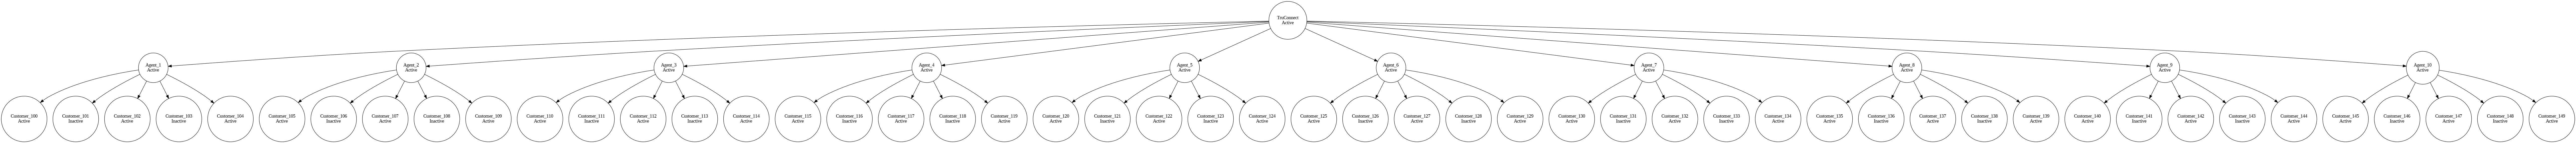

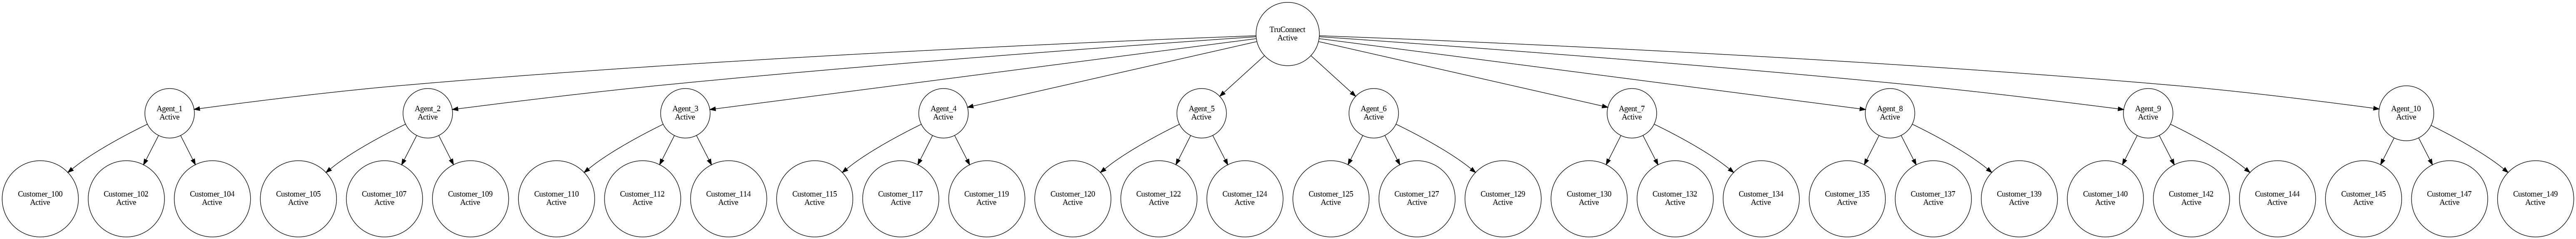

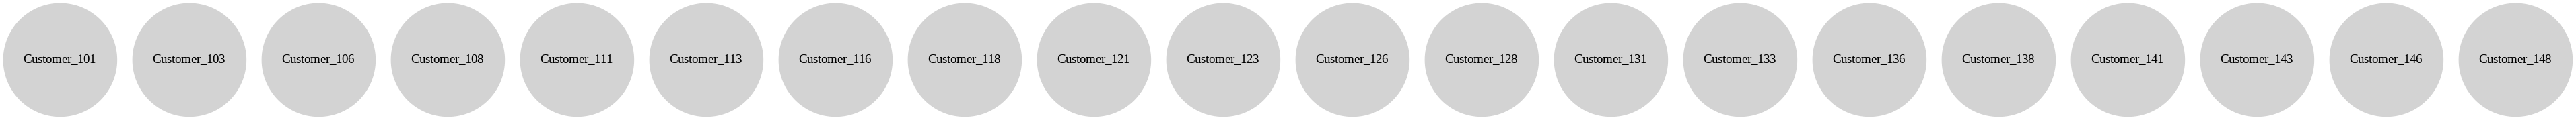

In [15]:
from IPython.display import Image

# Display the tree before archiving
display(Image('tree_before_archiving.png'))

# Display the tree after archiving
display(Image('tree_after_archiving.png'))

# Display archived nodes
display(Image('archived_nodes.png'))


In [22]:
import sqlite3

# Connect to the database (or create it)
conn = sqlite3.connect('user_tree.db')
cursor = conn.cursor()


In [23]:
import datetime

# Create tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    is_active BOOLEAN,
    last_activity TEXT,
    parent_id INTEGER,
    FOREIGN KEY (parent_id) REFERENCES users (user_id)
)
''')

# Function to insert a user and return the generated user_id
def insert_user(name, is_active, last_activity, parent_id=None):
    cursor.execute("INSERT INTO users (name, is_active, last_activity, parent_id) VALUES (?, ?, ?, ?)",
                   (name, is_active, last_activity, parent_id))
    return cursor.lastrowid

# Insert data
current_time = datetime.datetime.now().isoformat()

# Root user
truconnect_id = insert_user("TruConnect", True, current_time)

# Agents and Customers
for i in range(10):
    agent_id = insert_user(f"Agent_{i+1}", True, current_time, truconnect_id)

    for j in range(5):
        is_active = (j % 2 == 0)
        last_activity = (current_time if is_active else (datetime.datetime.now() - datetime.timedelta(days=400)).isoformat())
        insert_user(f"Customer_{i+1}_{j+1}", is_active, last_activity, agent_id)

# Commit the transaction
conn.commit()


In [24]:
# Fetch all users
cursor.execute("SELECT * FROM users")
users = cursor.fetchall()

# Print the users
print("All Users:")
for user in users:
    print(user)

# Archive inactive users
inactive_period_days = 365
inactive_date = (datetime.datetime.now() - datetime.timedelta(days=inactive_period_days)).isoformat()

cursor.execute("SELECT * FROM users WHERE is_active = ? AND last_activity < ?", (False, inactive_date))
inactive_users = cursor.fetchall()

# Print inactive users
print("\nInactive Users:")
for user in inactive_users:
    print(user)


All Users:
(1, 'TruConnect', 1, '2024-07-30T21:50:14.054567', None)
(2, 'Agent_1', 1, '2024-07-30T21:50:14.054567', 1)
(3, 'Agent_2', 1, '2024-07-30T21:50:14.054567', 1)
(4, 'Agent_3', 1, '2024-07-30T21:50:14.054567', 1)
(5, 'Agent_4', 1, '2024-07-30T21:50:14.054567', 1)
(6, 'Agent_5', 1, '2024-07-30T21:50:14.054567', 1)
(7, 'Agent_6', 1, '2024-07-30T21:50:14.054567', 1)
(8, 'Agent_7', 1, '2024-07-30T21:50:14.054567', 1)
(9, 'Agent_8', 1, '2024-07-30T21:50:14.054567', 1)
(10, 'Agent_9', 1, '2024-07-30T21:50:14.054567', 1)
(11, 'Agent_10', 1, '2024-07-30T21:50:14.054567', 1)
(100, 'Customer_100', 1, '2024-07-30T21:50:14.054567', 2)
(101, 'Customer_101', 0, '2023-06-26T21:50:14.055335', 2)
(102, 'Customer_102', 1, '2024-07-30T21:50:14.054567', 2)
(103, 'Customer_103', 0, '2023-06-26T21:50:14.055363', 2)
(104, 'Customer_104', 1, '2024-07-30T21:50:14.054567', 2)
(105, 'Customer_105', 1, '2024-07-30T21:50:14.054567', 3)
(106, 'Customer_106', 0, '2023-06-26T21:50:14.055381', 3)
(107, 'Custom

In [25]:
import sqlite3
import datetime

# Connect to the database (or create it)
conn = sqlite3.connect('user_tree.db')
cursor = conn.cursor()

# Function to create tables and insert sample data (if not already present)
def setup_database():
    # Create tables
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS users (
        user_id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT,
        is_active BOOLEAN,
        last_activity TEXT,
        parent_id INTEGER,
        FOREIGN KEY (parent_id) REFERENCES users (user_id)
    )
    ''')

    # Insert data if not present
    current_time = datetime.datetime.now().isoformat()

    # Check if data already exists
    cursor.execute("SELECT COUNT(*) FROM users")
    if cursor.fetchone()[0] > 0:
        return

    # Insert root user
    truconnect_id = insert_user("TruConnect", True, current_time)

    # Insert agents and customers
    for i in range(10):
        agent_id = insert_user(f"Agent_{i+1}", True, current_time, truconnect_id)
        for j in range(5):
            is_active = (j % 2 == 0)
            last_activity = (current_time if is_active else (datetime.datetime.now() - datetime.timedelta(days=400)).isoformat())
            insert_user(f"Customer_{i+1}_{j+1}", is_active, last_activity, agent_id)

def insert_user(name, is_active, last_activity, parent_id=None):
    cursor.execute("INSERT INTO users (name, is_active, last_activity, parent_id) VALUES (?, ?, ?, ?)",
                   (name, is_active, last_activity, parent_id))
    return cursor.lastrowid

setup_database()

# Query for agents with IDs 6 to 10 and their customers
agent_ids = (6, 7, 8, 9, 10)

# Fetch agents
cursor.execute("SELECT user_id, name FROM users WHERE user_id IN ({})".format(','.join('?'*len(agent_ids))), agent_ids)
agents = cursor.fetchall()

# Fetch customers for these agents
agent_ids_placeholder = ','.join('?'*len(agent_ids))
cursor.execute(f"SELECT user_id, name, parent_id FROM users WHERE parent_id IN ({agent_ids_placeholder})", agent_ids)
customers = cursor.fetchall()

# Print agents
print("Agents 6 to 10:")
for agent in agents:
    print(agent)

# Print customers of the agents
print("\nCustomers of Agents 6 to 10:")
for customer in customers:
    print(customer)

# Close the database connection
conn.close()


Agents 6 to 10:
(6, 'Agent_5')
(7, 'Agent_6')
(8, 'Agent_7')
(9, 'Agent_8')
(10, 'Agent_9')

Customers of Agents 6 to 10:
(120, 'Customer_120', 6)
(121, 'Customer_121', 6)
(122, 'Customer_122', 6)
(123, 'Customer_123', 6)
(124, 'Customer_124', 6)
(125, 'Customer_125', 7)
(126, 'Customer_126', 7)
(127, 'Customer_127', 7)
(128, 'Customer_128', 7)
(129, 'Customer_129', 7)
(130, 'Customer_130', 8)
(131, 'Customer_131', 8)
(132, 'Customer_132', 8)
(133, 'Customer_133', 8)
(134, 'Customer_134', 8)
(135, 'Customer_135', 9)
(136, 'Customer_136', 9)
(137, 'Customer_137', 9)
(138, 'Customer_138', 9)
(139, 'Customer_139', 9)
(140, 'Customer_140', 10)
(141, 'Customer_141', 10)
(142, 'Customer_142', 10)
(143, 'Customer_143', 10)
(144, 'Customer_144', 10)


In [19]:
conn.close()
